<a href="https://colab.research.google.com/github/FHnt97/TOM_Thesis/blob/main/WLK_%2B_MMH_Debiasing_Classification_Algorithms_2_0_TASK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fairness in Occupational Fatigue Detection
    

# Content

---

Find an introduction to the aim and dataset in the README file.

# Base code
------

Using the work by [Maman et al. (2020)](https://zahrame.github.io/FatigueManagement.github.io/) as a base, we apply a fairness unaware model, namely **SVM (circular kernel), RF and a generic LGM model (logistic regression).** 



### Libraries & helper functions

In [1]:
# importing general libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import Markdown, display

In [ ]:
# !pip install model-card-toolkit
!pip install --upgrade fairlearn==0.7.0
!pip install fairml
!pip install aif360

### Data load and wrangling

In [5]:
# connect to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# open csv datasets
# if using collab use -->
pathMMH = '/content/drive/MyDrive/00 - thesis/Thesis - Fabia Höhne/Datasets/Fatigue-modeling-master/MMH_15p.csv'
pathWLK = '/content/drive/MyDrive/00 - thesis/Thesis - Fabia Höhne/Datasets/Fatigue-modeling-master//WLK_13p.csv'

# if using the GitHub repo use -->
# pathMMH = './Datasets/Fatigue-modeling-master/MMH_15p.csv'
# pathWLK = './Datasets/Fatigue-modeling-master/WLK_13p.csv'

df_MMH = pd.read_csv(pathMMH, sep=',')
df_WLK = pd.read_csv(pathWLK, sep=',')

In [7]:
# make column names the same for both dfs
df_MMH['fatiguestate'] = df_MMH['fatiguestate1']
df_WLK['fatiguestate'] = df_WLK['Fatigue state']
df_WLK['subject'] = df_WLK['subject'].apply(lambda x: x+'00')

df_MMH.rename(columns = {'age':'Age', 'HRR-Mean': 'HRR.Mean', 'HRR-CV':'HRR.CV'}, inplace = True)
df_MMH.columns = df_MMH.columns.str.replace('coefficient.of.variation', 'CV')

df_MMH = df_MMH.drop(['fatiguestate1'], 1)
df_WLK = df_WLK.drop(['Fatigue state'], 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  # Remove the CWD from sys.path while we load stuff.


In [8]:
# merge datasets
df = pd.concat([df_MMH, df_WLK])

In [9]:
df = df.dropna(axis='columns')

In [10]:
# delete:
## fatiguestate (already in fatiguestate1); Unnamed (no critical information); gender (only available in one dataset)
df = df.drop(['Unnamed: 0'],1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
# convert subject to numerical values 
df['subject'] = df['subject'].str.replace('P','')

In [12]:
# bin age into groups to noramlize
def custom_round(x, base):
    return base * round(float(x)/10)

df['Age'] = df.Age.apply(lambda x: custom_round(x, 10))

In [13]:
# for this dataset features are NOT normalised, as preprocessing of data has already peen carried out by the owners of the dataset. How this is done is described in detail in their code & paper cited above. 
# in case of wanting to normalise, I would suggest normalising only mean values - variation has already been pre-calculated, and so is the HHR values (% of total possible HR)
# you can use (pandas or sklearn library 'preprocessing.MinMaxScaler'): 
# normalized_df=(df-df.min())/(df.max()-df.min())
# normalized_df=(df-df.mean())/df.std()


'''https://stackoverflow.com/questions/26414913/normalize-columns-of-pandas-data-frame'''

'https://stackoverflow.com/questions/26414913/normalize-columns-of-pandas-data-frame'

In [31]:
# convert task to numerical values 
df['task'] = df['task'].str.replace('MMH', '1')
df['task'] = df['task'].str.replace('WLK', '2')

## Stress Model

---


### Model set-up: libraries & helper functions

In [43]:
# libraries for data processing  
from sklearn.model_selection import train_test_split
from sklearn import preprocessing


# libraries for
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# libraries for feature selection
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.utils import Bunch

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit

# libraries for metrics of models
from sklearn.metrics import (
    accuracy_score, confusion_matrix,
    roc_curve, auc, roc_auc_score,
    plot_confusion_matrix,
    classification_report,
    balanced_accuracy_score,
    PrecisionRecallDisplay)
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GroupKFold


# libraries for fairness
from fairlearn.metrics import MetricFrame
from fairlearn.postprocessing import ThresholdOptimizer


from fairlearn.metrics import (
    MetricFrame,
    selection_rate, 
    demographic_parity_difference, 
    demographic_parity_ratio,
    false_positive_rate, 
    false_negative_rate,
    false_positive_rate_difference, 
    false_negative_rate_difference, 
    true_positive_rate, 
    true_negative_rate,
    selection_rate,
    count,
    equalized_odds_difference)


In [44]:
# Helper functions metrics
def get_metrics_df(models_dict, y_true, group):
    metrics_dict = {
        "Equalized_odds_difference": (
            lambda x: equalized_odds_difference(y_true, x, sensitive_features=group), True),
        "False negative rate difference": (
            lambda x: false_negative_rate_difference(y_true, x, sensitive_features=group), True),
        "Balanced error rate difference": (
            lambda x: MetricFrame(metrics=balanced_accuracy_score, y_true=y_true, y_pred=x, sensitive_features=group).difference(method='between_groups'), True),
        " ------": (lambda x: "", True),
        "Demographic parity difference": (
            lambda x: demographic_parity_difference(y_true, x, sensitive_features=group), True),
        "  ------": (lambda x: "", True),
        "Overall AUC": (
            lambda x: roc_auc_score(y_true, x), False),
        "AUC difference": (
            lambda x: MetricFrame(metrics=roc_auc_score, y_true=y_true, y_pred=x, sensitive_features=group).difference(method='between_groups'), False),
    }
    df_dict = {}
    for metric_name, (metric_func, use_preds) in metrics_dict.items():
        df_dict[metric_name] = [metric_func(preds) if use_preds else metric_func(scores) 
                                for model_name, (preds, scores) in models_dict.items()]
    return pd.DataFrame.from_dict(df_dict, orient="index", columns=models_dict.keys())

def metric_frame (feature):
    mf = MetricFrame({
        'FPR': false_positive_rate,
        'FNR': false_negative_rate,
        'TPR': true_positive_rate,
        'TNR': true_negative_rate, },
        y_test, test_preds, sensitive_features = feature)
    return mf.by_group


def summary_as_df(name, summary):
    a = summary.by_group
    a['overall'] = summary.overall
    return pd.DataFrame({name: a})

### Model set-up: test/train split 

In [45]:
# set test & train data & defining age as sensitive attribute
# fairness through unawareness if achieved by additionally dropping task and age
# X = df.drop(columns=['task', 'Age', 'fatiguestate'])
X = df.drop(columns=['fatiguestate'])

y = df['fatiguestate']

A = df[['Age', 'task']]
task_str = A['task'].map({ 1:"MMK", 2:"WLK"})

In [46]:
# for fairnes measures (inlc. A for group classification, drop age to make it unaware to other senstive attributes (fairnes through unawarenes)) - AGE 
X_train, X_test, y_train, y_test, A_train, A_test, task_str_train, task_str_test = train_test_split(
    X, 
    y, 
    A, 
    task_str,
    test_size = 0.4, # increse number for more fairness 
    random_state=42)


### Model set-up: defining classifiers

In [60]:
from numpy import random 
# set up model:
classifiers = [RandomForestClassifier(n_estimators = 100, random_state = random.seed(123)),
               LogisticRegression(random_state = 42, solver = 'newton-cg', C=1000000),
               SVC(kernel='rbf', C = 64, gamma = 0.01, class_weight='balanced', probability = True)]

## Model evaluation
-----

### Model evaluation - confusion matrix test & train

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMa

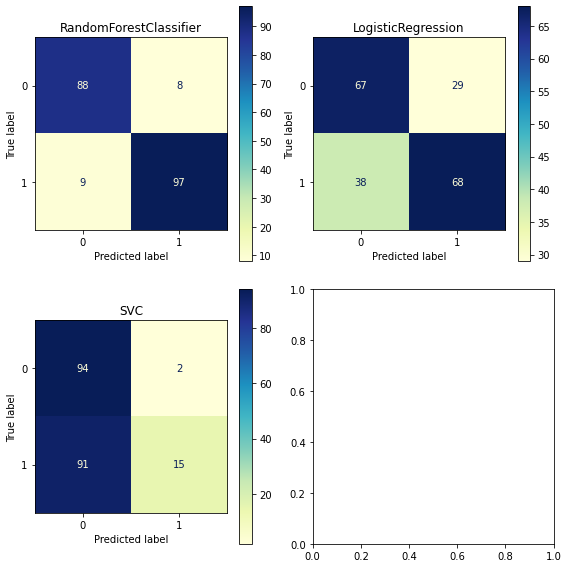

In [35]:
# test set
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

for cls, ax in zip(classifiers, axes.flatten()):
    cls.fit(X_train, y_train)
    plot_confusion_matrix(cls, 
                          X_test, 
                          y_test, 
                          ax=ax, 
                          cmap='YlGnBu')
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()
plt.show()

## Fairness Measure

---



### Fairness evaluation - confusion matrix by group


In [48]:
# define sensitive attributes
task = A_test['task']

for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  # scores on test set
  y_pred = model.predict_proba(X_test)[:, 1]

  # predictions (0 or 1) on test set
  test_preds = (y_pred >= np.mean(y_train)) * 1

  print(f'Age:{chr(10)}{model}: {chr(10)} {metric_frame (age)} {chr(10)}')
  print(f'Task:{chr(10)}{model}: {chr(10)} {metric_frame (task)} {chr(10)}')



/usr/local/lib/python3.7/dist-packages/fairlearn/metrics/_metric_frame.py:67: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/fairlearn/metrics/_metric_frame.py:67: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  FutureWarning)


Age:
RandomForestClassifier(): 
           FPR       FNR       TPR       TNR
Age                                        
20   0.176471       0.0       1.0  0.823529
30   0.230769       0.0       1.0  0.769231
40       0.05  0.052632  0.947368      0.95
60   0.068966  0.138889  0.861111  0.931034 

Task:
RandomForestClassifier(): 
            FPR       FNR       TPR       TNR
task                                        
1     0.178571  0.033898  0.966102  0.821429
2         0.05  0.085106  0.914894      0.95 



/usr/local/lib/python3.7/dist-packages/fairlearn/metrics/_metric_frame.py:67: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/fairlearn/metrics/_metric_frame.py:67: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/fairlearn/metrics/_metric_frame.py:67: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/fairlearn/metrics/_metric_frame.py:67: FutureWarn

Age:
LogisticRegression(C=1000000, random_state=42, solver='newton-cg'): 
           FPR       FNR       TPR       TNR
Age                                        
20   0.470588   0.27027   0.72973  0.529412
30   0.384615  0.285714  0.714286  0.615385
40        0.4  0.315789  0.684211       0.6
60   0.137931  0.333333  0.666667  0.862069 

Task:
LogisticRegression(C=1000000, random_state=42, solver='newton-cg'): 
            FPR       FNR       TPR       TNR
task                                        
1     0.446429  0.355932  0.644068  0.553571
2          0.2  0.234043  0.765957       0.8 

Age:
SVC(C=64, class_weight='balanced', gamma=0.01, probability=True): 
           FPR       FNR       TPR       TNR
Age                                        
20   0.735294  0.027027  0.972973  0.264706
30   0.923077       0.0       1.0  0.076923
40        0.6       0.0       1.0       0.4
60   0.551724  0.027778  0.972222  0.448276 

Task:
SVC(C=64, class_weight='balanced', gamma=0.01, probabili

### Fairness evaluation - fairness metrics by group (equalized odds, demographic parity difference & ratio, false negative rate difference)

In [50]:
for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  # scores on test set
  y_pred = model.predict_proba(X_test)[:, 1]

  # predictions (0 or 1) on test set
  test_preds = (y_pred >= np.mean(y_train)) * 1

  models_dict = {"Unmitigated": (test_preds, y_pred)}

  print(f'Task:{chr(10)}{model}: {chr(10)} {get_metrics_df(models_dict, y_test, task)} {chr(10)}')

Task:
RandomForestClassifier(): 
                                Unmitigated
Equalized_odds_difference         0.092857
False negative rate difference     0.01731
Balanced error rate difference    0.037774
 ------                                   
Demographic parity difference     0.030585
  ------                                  
Overall AUC                       0.966637
AUC difference                    0.010403 

Task:
LogisticRegression(C=1000000, random_state=42, solver='newton-cg'): 
                                Unmitigated
Equalized_odds_difference         0.246429
False negative rate difference     0.12189
Balanced error rate difference    0.184159
 ------                                   
Demographic parity difference     0.042079
  ------                                  
Overall AUC                        0.76818
AUC difference                     0.15437 

Task:
SVC(C=64, class_weight='balanced', gamma=0.01, probability=True): 
                                Unmitig

##### helper function for visualisation


In [51]:
# demographic disparity
# https://github.com/fairlearn/fairlearn/blob/main/notebooks/Mitigating%20Disparities%20in%20Ranking%20from%20Binary%20Data.ipynb

from IPython.display import display, HTML
import matplotlib.pyplot as plt
from scipy.stats import cumfreq

def compare_cdfs(data, A, num_bins=100):
    cdfs = {}
    assert len(np.unique(A)) == 2 ### change to 4/2 depending on the sensitive attribute (Age vs. task)
    
    limits = ( min(data), max(data) )
    s = 0.5 * (limits[1] - limits[0]) / (num_bins - 1)
    limits = ( limits[0]-s, limits[1] + s)
    
    for a in np.unique(A):
        subset = data[A==a]
        
        cdfs[a] = cumfreq(subset, numbins=num_bins, defaultreallimits=limits)
        
    lower_limits = [v.lowerlimit for _, v in cdfs.items()]
    bin_sizes = [v.binsize for _,v in cdfs.items()]
    actual_num_bins = [v.cumcount.size for _,v in cdfs.items()]
    
    assert len(np.unique(lower_limits)) == 1
    assert len(np.unique(bin_sizes)) == 1
    assert np.all([num_bins==v.cumcount.size for _,v in cdfs.items()])
    
    xs = lower_limits[0] + np.linspace(0, bin_sizes[0]*num_bins, num_bins)
    
    disparities = np.zeros(num_bins)
    for i in range(num_bins):
        cdf_values = np.clip([v.cumcount[i]/len(data[A==k]) for k,v in cdfs.items()],0,1)
        disparities[i] = max(cdf_values)-min(cdf_values)  
    
    return xs, cdfs, disparities
    
    
def plot_and_compare_cdfs(data, A, num_bins=100, loc='best'):
    xs, cdfs, disparities = compare_cdfs(data, A, num_bins)
    
    for k, v in cdfs.items():
        plt.plot(xs, v.cumcount/len(data[A==k]), label=k)
    
    assert disparities.argmax().size == 1
    d_idx = disparities.argmax()
    
    xs_line = [xs[d_idx],xs[d_idx]]
    counts = [v.cumcount[d_idx]/len(data[A==k]) for k, v in cdfs.items()]
    ys_line = [min(counts), max(counts)]
    
    plt.plot(xs_line, ys_line, 'o--')
    disparity_label = "max disparity = {0:.3f}\nat {1:0.3f}".format(disparities[d_idx], xs[d_idx])
    plt.text(xs[d_idx], 1, disparity_label, ha="right", va="top")
    
    plt.ylabel("cumulative frequency")
    plt.legend(loc=loc)
    plt.show()

#### Visualisation - performance metric by groups (age)


---



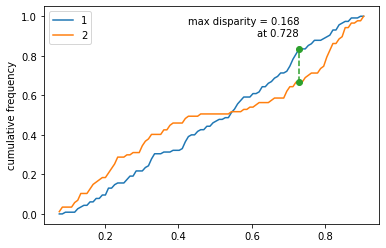

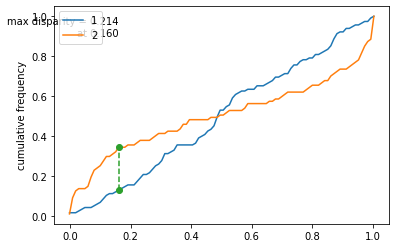

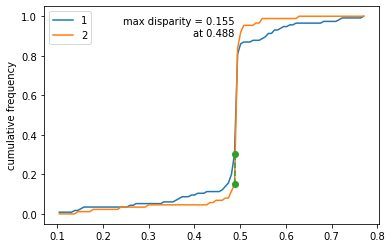

In [52]:
%matplotlib inline

for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  # scores on test set
  y_pred = model.predict_proba(X_test)[:, 1]

  # predictions (0 or 1) on test set
  test_preds = (y_pred >= np.mean(y_train)) * 1


  display(HTML('<span id="disparity_unmitigated">'))
  plot_and_compare_cdfs(y_pred, task)
  display(HTML('</span>'))

# Debiasing the model

---


#### import libraries and helper functions

In [53]:
import aif360

from aif360.datasets import StandardDataset
from sklearn.pipeline import make_pipeline 

# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import DatasetMetric

from aif360.metrics import ClassificationMetric

# Explainers
from aif360.explainers import MetricTextExplainer

# Scalers
from sklearn.preprocessing import StandardScaler

# Bias mitigation techniques
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.algorithms.inprocessing import PrejudiceRemover

# fairlearn libraries
from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer
from fairlearn.postprocessing._interpolated_thresholder import InterpolatedThresholder
from fairlearn.postprocessing._threshold_operation import ThresholdOperation

from fairlearn.reductions import (ExponentiatedGradient, 
                                  EqualizedOdds, 
                                  ErrorRateParity)


In [54]:
# define for the metric frame
metrics = {
    'accuracy': accuracy_score,
    'false positive rate': false_positive_rate,
    'false negative rate': false_negative_rate,
    'selection rate': selection_rate,
    'count': count,
    'balanced error rate': balanced_accuracy_score}

#### 1. Reweigh samples for age (AIF360)

Based on:
1. [Correcting Unfair Binary Classification
Models](http://arno.uvt.nl/show.cgi?fid=157880)

2. [AIF360 example](https://nbviewer.org/github/IBM/AIF360/blob/master/examples/tutorial_credit_scoring.ipynb)


In [56]:
# set dataset in aif360 format
ds_aif = aif360.datasets.StandardDataset (df, 
                                         label_name="fatiguestate",
                                         favorable_classes = [1], 
                                         protected_attribute_names=['task'], 
                                         privileged_classes= [lambda x: x >= 0],
                                         features_to_drop=['subject'])

TypeError: ignored

In [ ]:
# test, train split
ds_train, ds_test = ds_aif.split([0.67], shuffle=True)

In [ ]:
# pre-processing - reweighing 
# define priviledged & unpriviledged groups
unpriv = [{'task': 0}]
priv = [{'task': 1}]

# reweigh
RW = Reweighing (unprivileged_groups = unpriv, 
                 privileged_groups = priv)

RW_train = RW.fit_transform(ds_train)

In [ ]:
# check for metric before and after transforming 
# OG dataset
metric_train = BinaryLabelDatasetMetric(ds_train,
                                        unprivileged_groups = unpriv,
                                        privileged_groups = priv)

explainer_train = MetricTextExplainer(metric_train)

# transformed dataset
metric_transf_train = BinaryLabelDatasetMetric(RW_train,
                                               unprivileged_groups=unpriv,
                                               privileged_groups=priv)

explainer_transf_train = MetricTextExplainer(metric_transf_train)

In [ ]:
# refit rfc model & get metrics
X_train = RW_train.features
y_train = RW_train.labels.ravel()
w_train = RW_train.instance_weights

X_test = ds_test.features
y_test = ds_test.labels.ravel()

##### Evaluations

In [ ]:
# confusion matrix

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

for cls, ax in zip(classifiers, axes.flatten()):
    # train models with reweighted data
    dataset = RW_train
    cls.fit(dataset.features, dataset.labels.ravel(), sample_weight = dataset.instance_weights)
    
    # plot
    plot_confusion_matrix(cls, 
                          X_test, 
                          y_test, 
                          ax=ax, 
                          cmap='YlGnBu')
    ax.title.set_text(type(cls).__name__)

plt.tight_layout()
plt.show()

In [ ]:
# double check with train set
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

for cls, ax in zip(classifiers, axes.flatten()):
    dataset = RW_train
    cls.fit(dataset.features, dataset.labels.ravel(), sample_weight = dataset.instance_weights)
    plot_confusion_matrix(cls, 
                          X_train, 
                          y_train, 
                          ax=ax, 
                          cmap='YlGnBu')
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()
plt.show()

In [ ]:
# get classification reports
for cls in classifiers:
  cls.fit(dataset.features, dataset.labels.ravel(), sample_weight = dataset.instance_weights)
  y_pred = cls.predict(X_test)
  
  print(f'{cls}: {chr(10)} {classification_report(y_test, y_pred)}')

##### Fairness evaluations

In [ ]:
# define test 
ds_test_pred = ds_test.copy(deepcopy=True)

In [ ]:
for cls in classifiers:
  dataset = RW_train
  cls.fit(dataset.features, dataset.labels.ravel(), sample_weight = dataset.instance_weights)
  y_pred = cls.predict(X_test)
  
  # scores on test set
  ds_test_pred.scores = cls.predict_proba(X_test)[:1]

  # predictions (0 or 1) on test set
  y_train_pred = cls.predict(X_train)
  test_preds = (y_pred >= np.mean(y_train)) * 1

  models_dict = {"mitigated_pre-processing": (test_preds, y_pred)}

  print(f'Age:{chr(10)}{cls}: {chr(10)} {get_metrics_df(models_dict, y_test, age)} {chr(10)}') 
  print(f'Age:{chr(10)}{cls}: {chr(10)} {metric_frame (age)} {chr(10)}') 

  mf1 = MetricFrame(metrics=metrics,
                    y_true=y_test,
                    y_pred=y_pred,
                    sensitive_features=age)
  

  
  models_dict = {"mitigated_pre-processing": (test_preds, y_pred)}

# The disaggregated metrics are stored in a pandas Series mf1.by_group:
  print(f"{cls}:\n {mf1.by_group}\n")
  print(f"{cls} difference:\n {mf1.difference(method='between_groups')}\n")

### Fair learn - post processign methods



In [57]:
# set test & train data & defining age as sensitive attribute
X = df.drop(columns=['Age', 'task', 'fatiguestate'])
y = df['fatiguestate']

A = df[['Age']]


# for fairnes measures (inlc. A for group classification, drop age to make it unaware to other senstive attributes (fairnes through unawarenes)) - AGE 
X_train, X_test, y_train, y_test, A_train, A_test, A_str_train, A_str_test = train_test_split(
    X, 
    y, 
    A, 
    task_str,
    test_size = 0.33, # increse number for more fairness 
    random_state=42)


#### 3. ExponentiatedGradient - reduction (fair learn)


---


Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Seri

RandomForestClassifier():
     ExponentiatedGradient                                          \
                 accuracy false positive rate false negative rate   
Age                                                                 
20               0.885246                 0.2            0.032258   
30               0.954545                 0.1                 0.0   
40                    1.0                 0.0                 0.0   
60               0.909091                 0.0             0.15625   

                                              
    selection rate count balanced error rate  
Age                                           
20        0.590164    61            0.883871  
30        0.590909    22                0.95  
40        0.535714    28                 1.0  
60        0.490909    55            0.921875  

RandomForestClassifier() difference:
 accuracy               0.114754
false positive rate         0.2
false negative rate     0.15625
selection rate           

ValueError: ignored

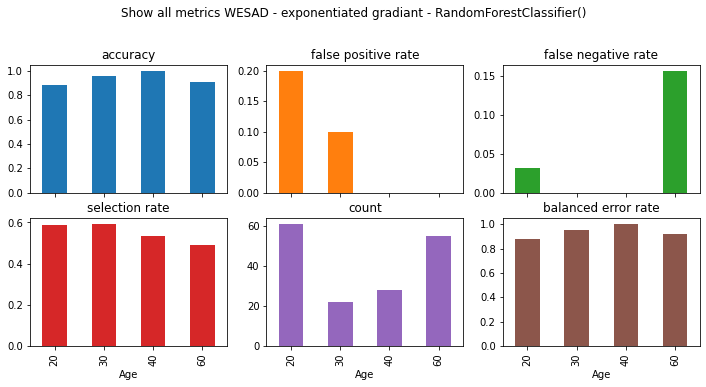

In [62]:
# train exponentialgradient for each classifier
# get metrics resuts

for cls in classifiers:
  expgrad_est = ExponentiatedGradient(estimator=cls,
                                    constraints=ErrorRateParity(difference_bound=0.01)) # for FNR 1-TPR
  
  expgrad_est.fit(X_train, y_train, sensitive_features=A_train)
  
  y_pred_reductions = expgrad_est.predict(X_test)
  
  
  mf_eg =  MetricFrame(metrics=metrics,
                                       y_true=y_test,
                                       y_pred=y_pred_reductions,
                                       sensitive_features=A_test
                                       )
  
  df_results = pd.concat([mf_eg.by_group],
                          keys=['ExponentiatedGradient'],
                          axis=1)
  
  print (f'{cls}:{chr(10)} {df_results}{chr(10)}')
  print(f"{cls} difference:\n {mf_eg.difference(method='between_groups')}\n")


  # visualize mitigated
  mf_eg.by_group.plot(
      kind="bar",
  #    ylim=[0, 1],
      subplots=True,
      layout=[3, 3],
      legend=False,
      figsize=[12, 8],
      title=f'Show all metrics WESAD - exponentiated gradiant - {cls}',
  )



  y_train_pred = cls.predict(X_train)
  test_preds = (y_pred_reductions >= np.mean(y_train)) * 1

  models_dict = {"mitigated_pre-processing": (test_preds, y_pred)}

  print(f':{chr(10)}{cls}: {chr(10)} {get_metrics_df(models_dict, y_test, A_test)} {chr(10)}') 

#### 4. Thresholdoptimizer (fair learn - post processing)

ThresholdOptimizer takes in an exisiting (possibly pre-fit) machine learning model whose predictions act as a scoring function and identifies a separate thrceshold for each group in order to optimize some specified objective metric (such as balanced accuracy) subject to specified fairness constraints (such as false negative rate parity). Thus, the resulting classifier is just a suitably thresholded version of the underlying machinelearning model.

In [63]:
# fit thesholdoptimizer for each classifier and return mitigated resutls
for cls in classifiers: 
    unmitigated_pipeline = Pipeline(steps=[("model", cls)])

    unmitigated_pipeline.fit(X_train, y_train)
    
    postprocess_est = ThresholdOptimizer(estimator=unmitigated_pipeline,
                                        constraints="equalized_odds",
                                        objective="balanced_accuracy_score",
                                        prefit=True,
                                        predict_method='predict_proba')
    
    postprocess_est.fit(X_train, y_train, sensitive_features=A_train) # change a test in train/ test sample

    y_pred_postprocess = postprocess_est.predict(X_test, sensitive_features=A_test) 

    mf_to = MetricFrame(metrics=metrics,
                                          y_true=y_test,
                                          y_pred=y_pred_postprocess,
                                          sensitive_features=A_test) 
    
    df_results = pd.concat([mf_to.by_group],
                            keys=['ThresholdOptimizer'],
                            axis=1)

    print (f'{cls}:{chr(10)} {df_results}{chr(10)}')

    print(f"{cls} difference:\n {mf_to.difference(method='between_groups')}\n")
    
    y_train_pred = cls.predict(X_train)
    test_preds = (y_pred_postprocess >= np.mean(y_train)) * 1

    models_dict = {"mitigated_pre-processing": (test_preds, y_pred)}

    print(f':{chr(10)}{cls}: {chr(10)} {get_metrics_df(models_dict, y_test, A_test)} {chr(10)}') 

    # visualize mitigated
    mf_to.by_group.plot(
        kind="bar",
    #    ylim=[0, 1],
        subplots=True,
        layout=[3, 3],
        legend=False,
        figsize=[12, 8],
        title=f'Show all metrics WESAD - thresholdoptimizer - {cls}',
    )

RandomForestClassifier():
     ThresholdOptimizer                                                         \
              accuracy false positive rate false negative rate selection rate   
Age                                                                             
20            0.885246            0.166667            0.064516       0.557377   
30            0.909091                 0.2                 0.0       0.636364   
40            0.964286                 0.0            0.066667            0.5   
60            0.854545                 0.0                0.25       0.436364   

                               
    count balanced error rate  
Age                            
20     61            0.884409  
30     22                 0.9  
40     28            0.966667  
60     55               0.875  

RandomForestClassifier() difference:
 accuracy                0.10974
false positive rate         0.2
false negative rate        0.25
selection rate              0.2
count         

ValueError: ignored